In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect= True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Investigate the Database


In [9]:
from sqlalchemy import inspect
inspector = inspect(engine)

In [10]:
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"],column["type"],primarykeystr)

id INTEGER Primary Key
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [12]:
columns = inspector.get_columns('station')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"], column["type"], primarykeystr)

id INTEGER Primary Key
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


# Exploratory Precipitation Analysis

In [13]:
# How many dates are recorded?
session.query(func.count(Measurement.date)).all()

[(19550,)]

In [14]:
# Find the most recent date in the data set.
recent_date_str=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date_str)

('2017-08-23',)


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
recent_date = dt.date.fromisoformat(recent_date_str[0])
prev_year = recent_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
scores = [Measurement.date,Measurement.prcp]
query_data= session.query(*scores).filter(Measurement.date>=prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df=pd.DataFrame(query_data,columns=['Date','Precipitation'])

# Set index to date
prcp_df.set_index('Date', inplace=True)

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(by='Date')


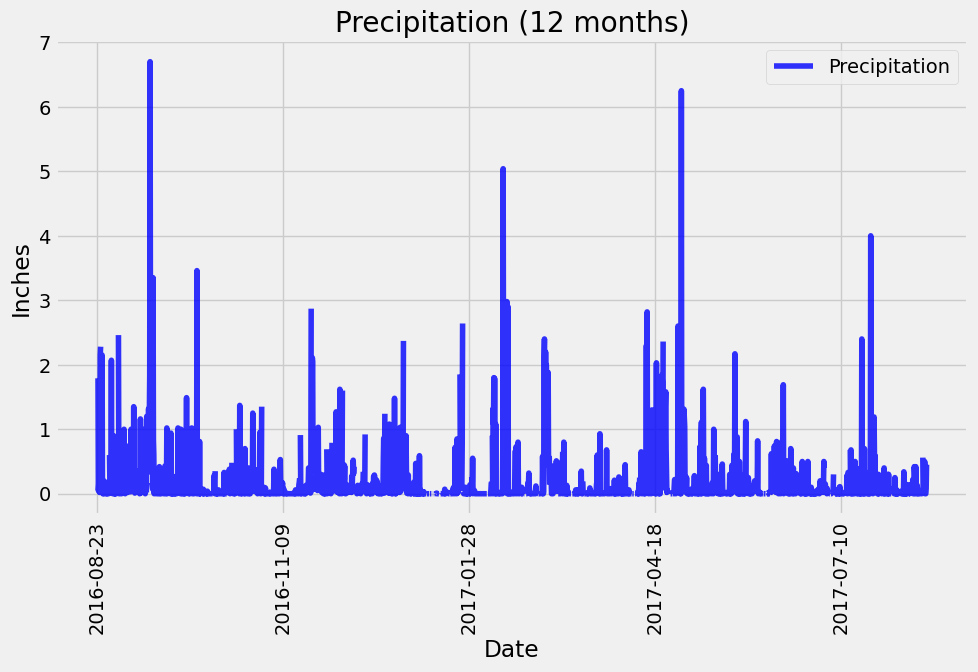

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.plot(title="Precipitation (12 months)", color='blue', alpha=0.8, figsize=(10,6))
plt.legend(loc='upper right')
plt.ylabel("Inches")
plt.xlabel("Date")
plt.tight_layout()
plt.xticks(rotation="vertical")
plt.savefig("Images/precipitation")
plt.show()


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
total_stations= session.query(Station.id).count()
total_stations

9

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
active_stations = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_data=active_stations[0][0]
most_active_temps_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station_data).all()
print(f"Most Active Station Temperatures")
print(f"Low: {most_active_temps_data[0][0]} High: {most_active_temps_data[0][1]} Average: {round(most_active_temps_data[0][2], 1)}")

    

Most Active Station Temperatures
Low: 54.0 High: 85.0 Average: 71.7


In [20]:
# Choose the station with the highest number of temperature observations.

highest_tob_station = session.query(Measurement.station, func.count(Measurement.tobs)).\
  group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
highest_tob_station= highest_tob_station[0]
highest_tob_station


'USC00519281'

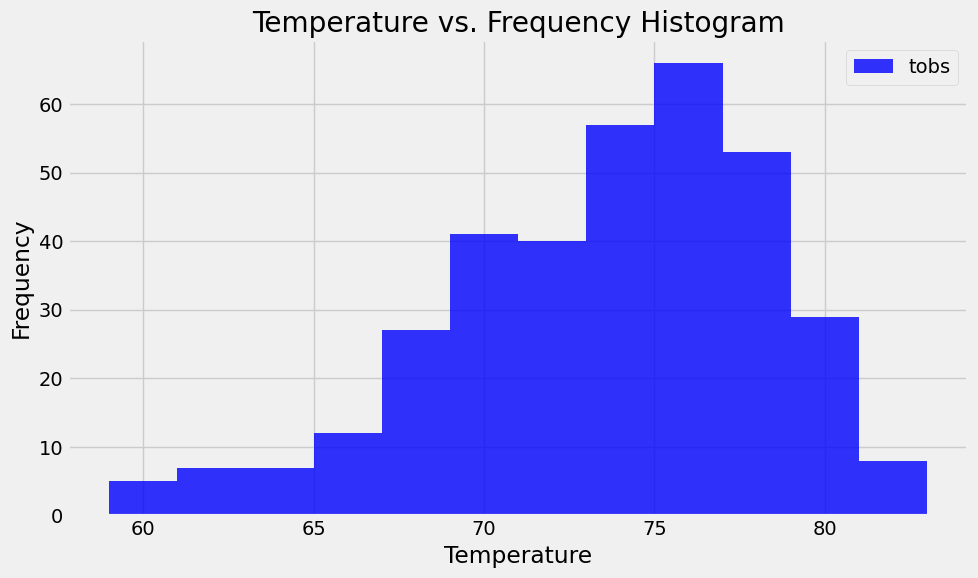

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observations = session.query( Measurement.tobs).\
  filter(Measurement.date >= prev_year).filter(Measurement.station == highest_tob_station).all()
temperature_observations = pd.DataFrame(temperature_observations, columns=['tobs'])
temperature_observations.plot(kind='hist',bins=12, title="Temperature vs. Frequency Histogram",color='blue', alpha=0.8, figsize=(10,6))
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.tight_layout()
plt.savefig("Images/tobs")
plt.show()

# Close session

In [22]:
# Close Session
session.close()